In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [9]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [10]:
res = rle2mask("5 4 11 1 13 1 16 4", 5, 5)
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Xception Model in Keras

In [11]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 256
TRAIN_IMG_SIZE_WIDTH = 256

NO_OF_CLASSES = 4

BATCH_SIZE = 4


In [12]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, img_path, orig_img_shape, new_img_shape=None, batch_size = BATCH_SIZE, n_channels=1,
                 n_classes=4, shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.orig_img_shape = orig_img_shape
        if new_img_shape:
            self.new_img_shape = new_img_shape
        else:
            self.new_img_shape = orig_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.new_img_shape, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size, *self.new_img_shape, 1), dtype=np.uint8)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            if self.orig_img_shape != self.new_img_shape:
                img = cv2.resize(img, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img
            
            mask_i = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *self.orig_img_shape)            
            img_mask_i = Image.fromarray(mask_i, 'L')
            img_mask_np = np.array(img_mask_i) 
            
            if self.orig_img_shape != self.new_img_shape:
                img_mask_np = cv2.resize(img_mask_np, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = img_mask_np
            
        return X, y

In [13]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [14]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def advanced_unet_256_segmentation_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape) # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0) # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1) # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2) # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3) # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4) # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4) # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3) # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1) # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0) # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [15]:
advanced_model = advanced_unet_256_segmentation_model()
advanced_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
_____________________________________

activation_11 (Activation)      (None, 8, 8, 1024)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 8, 8, 1024)   9438208     activation_11[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 8, 8, 1024)   4096        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 8, 8, 1024)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 16, 16, 1024) 0           activation_12[0][0]              
__________________________________________________________________________________________________
concatenat

conv2d_22 (Conv2D)              (None, 128, 128, 64) 110656      concatenate_4[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 128, 128, 64) 256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 128, 128, 64) 0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 128, 128, 64) 36928       activation_22[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 128, 128, 64) 256         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation

In [16]:
from keras.optimizers import RMSprop

advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [17]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss', 
        patience=patient, 
        mode='max', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./Xcep_model_CD_LR0_01.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, RR]
    return [ES, MC, LR]


In [18]:
idx = int(0.8*len(df_train))
train_batches = DataGenerator(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=False)
valid_batches = DataGenerator(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=False)

history = advanced_model.fit_generator(train_batches,
                              epochs=3,    
                              validation_data=valid_batches,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(2)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/3

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.


 131/1419 [=>............................] - ETA: 4:37:58 - loss: 0.2606 - dice_coeff: 0.0400 - acc: 0.618 - ETA: 2:21:16 - loss: 0.2069 - dice_coeff: 0.0823 - acc: 0.665 - ETA: 1:35:40 - loss: 0.1010 - dice_coeff: 0.1207 - acc: 0.696 - ETA: 1:12:48 - loss: 0.1039 - dice_coeff: 0.1124 - acc: 0.754 - ETA: 59:08 - loss: 0.0858 - dice_coeff: 0.1075 - acc: 0.7823  - ETA: 50:04 - loss: 0.0680 - dice_coeff: 0.1120 - acc: 0.795 - ETA: 43:33 - loss: 0.0703 - dice_coeff: 0.1012 - acc: 0.822 - ETA: 38:40 - loss: 0.0631 - dice_coeff: 0.0958 - acc: 0.841 - ETA: 34:51 - loss: 0.0555 - dice_coeff: 0.0917 - acc: 0.855 - ETA: 31:48 - loss: 0.0549 - dice_coeff: 0.0858 - acc: 0.868 - ETA: 29:21 - loss: 0.0359 - dice_coeff: 0.0936 - acc: 0.866 - ETA: 27:16 - loss: 0.0148 - dice_coeff: 0.1021 - acc: 0.869 - ETA: 25:31 - loss: 0.0205 - dice_coeff: 0.0966 - acc: 0.878 - ETA: 24:00 - loss: 0.0184 - dice_coeff: 0.0954 - acc: 0.884 - ETA: 22:41 - loss: 0.0191 - dice_coeff: 0.0919 - acc: 0.890 - ETA: 21:34 - lo

 263/1419 [====>.........................] - ETA: 6:09 - loss: -0.1449 - dice_coeff: 0.1482 - acc: 0.912 - ETA: 6:08 - loss: -0.1459 - dice_coeff: 0.1493 - acc: 0.912 - ETA: 6:07 - loss: -0.1468 - dice_coeff: 0.1495 - acc: 0.912 - ETA: 6:06 - loss: -0.1481 - dice_coeff: 0.1501 - acc: 0.912 - ETA: 6:05 - loss: -0.1491 - dice_coeff: 0.1506 - acc: 0.912 - ETA: 6:04 - loss: -0.1505 - dice_coeff: 0.1513 - acc: 0.912 - ETA: 6:03 - loss: -0.1533 - dice_coeff: 0.1524 - acc: 0.912 - ETA: 6:02 - loss: -0.1553 - dice_coeff: 0.1536 - acc: 0.912 - ETA: 6:01 - loss: -0.1563 - dice_coeff: 0.1542 - acc: 0.912 - ETA: 6:00 - loss: -0.1604 - dice_coeff: 0.1562 - acc: 0.912 - ETA: 5:59 - loss: -0.1646 - dice_coeff: 0.1579 - acc: 0.913 - ETA: 5:58 - loss: -0.1634 - dice_coeff: 0.1581 - acc: 0.912 - ETA: 5:57 - loss: -0.1651 - dice_coeff: 0.1589 - acc: 0.912 - ETA: 5:56 - loss: -0.1672 - dice_coeff: 0.1600 - acc: 0.912 - ETA: 5:55 - loss: -0.1687 - dice_coeff: 0.1607 - acc: 0.912 - ETA: 5:54 - loss: -0.1741

 395/1419 [=======>......................] - ETA: 4:41 - loss: -0.2992 - dice_coeff: 0.2254 - acc: 0.913 - ETA: 4:41 - loss: -0.3011 - dice_coeff: 0.2262 - acc: 0.913 - ETA: 4:40 - loss: -0.3021 - dice_coeff: 0.2266 - acc: 0.914 - ETA: 4:40 - loss: -0.3011 - dice_coeff: 0.2263 - acc: 0.914 - ETA: 4:39 - loss: -0.3020 - dice_coeff: 0.2266 - acc: 0.914 - ETA: 4:39 - loss: -0.3013 - dice_coeff: 0.2261 - acc: 0.914 - ETA: 4:38 - loss: -0.3021 - dice_coeff: 0.2265 - acc: 0.914 - ETA: 4:38 - loss: -0.3015 - dice_coeff: 0.2265 - acc: 0.914 - ETA: 4:38 - loss: -0.3012 - dice_coeff: 0.2266 - acc: 0.914 - ETA: 4:37 - loss: -0.3010 - dice_coeff: 0.2264 - acc: 0.914 - ETA: 4:37 - loss: -0.3029 - dice_coeff: 0.2273 - acc: 0.914 - ETA: 4:36 - loss: -0.3037 - dice_coeff: 0.2276 - acc: 0.914 - ETA: 4:36 - loss: -0.3036 - dice_coeff: 0.2275 - acc: 0.914 - ETA: 4:35 - loss: -0.3062 - dice_coeff: 0.2286 - acc: 0.914 - ETA: 4:35 - loss: -0.3073 - dice_coeff: 0.2293 - acc: 0.914 - ETA: 4:35 - loss: -0.3072

 527/1419 [==========>...................] - ETA: 3:54 - loss: -0.3581 - dice_coeff: 0.2532 - acc: 0.917 - ETA: 3:54 - loss: -0.3580 - dice_coeff: 0.2534 - acc: 0.917 - ETA: 3:53 - loss: -0.3578 - dice_coeff: 0.2532 - acc: 0.917 - ETA: 3:53 - loss: -0.3581 - dice_coeff: 0.2535 - acc: 0.917 - ETA: 3:53 - loss: -0.3581 - dice_coeff: 0.2534 - acc: 0.917 - ETA: 3:52 - loss: -0.3573 - dice_coeff: 0.2531 - acc: 0.917 - ETA: 3:52 - loss: -0.3588 - dice_coeff: 0.2538 - acc: 0.917 - ETA: 3:52 - loss: -0.3581 - dice_coeff: 0.2535 - acc: 0.917 - ETA: 3:51 - loss: -0.3590 - dice_coeff: 0.2539 - acc: 0.917 - ETA: 3:51 - loss: -0.3589 - dice_coeff: 0.2540 - acc: 0.916 - ETA: 3:51 - loss: -0.3603 - dice_coeff: 0.2547 - acc: 0.916 - ETA: 3:51 - loss: -0.3614 - dice_coeff: 0.2552 - acc: 0.916 - ETA: 3:50 - loss: -0.3604 - dice_coeff: 0.2546 - acc: 0.916 - ETA: 3:50 - loss: -0.3609 - dice_coeff: 0.2548 - acc: 0.916 - ETA: 3:50 - loss: -0.3611 - dice_coeff: 0.2549 - acc: 0.916 - ETA: 3:49 - loss: -0.3622

 659/1419 [============>.................] - ETA: 3:17 - loss: -0.4101 - dice_coeff: 0.2785 - acc: 0.918 - ETA: 3:17 - loss: -0.4105 - dice_coeff: 0.2786 - acc: 0.918 - ETA: 3:17 - loss: -0.4113 - dice_coeff: 0.2789 - acc: 0.918 - ETA: 3:16 - loss: -0.4113 - dice_coeff: 0.2789 - acc: 0.918 - ETA: 3:16 - loss: -0.4116 - dice_coeff: 0.2792 - acc: 0.918 - ETA: 3:16 - loss: -0.4117 - dice_coeff: 0.2792 - acc: 0.918 - ETA: 3:16 - loss: -0.4123 - dice_coeff: 0.2794 - acc: 0.918 - ETA: 3:15 - loss: -0.4129 - dice_coeff: 0.2796 - acc: 0.918 - ETA: 3:15 - loss: -0.4136 - dice_coeff: 0.2800 - acc: 0.918 - ETA: 3:15 - loss: -0.4137 - dice_coeff: 0.2800 - acc: 0.918 - ETA: 3:15 - loss: -0.4143 - dice_coeff: 0.2803 - acc: 0.918 - ETA: 3:14 - loss: -0.4149 - dice_coeff: 0.2805 - acc: 0.919 - ETA: 3:14 - loss: -0.4152 - dice_coeff: 0.2807 - acc: 0.919 - ETA: 3:14 - loss: -0.4152 - dice_coeff: 0.2806 - acc: 0.919 - ETA: 3:14 - loss: -0.4162 - dice_coeff: 0.2811 - acc: 0.919 - ETA: 3:13 - loss: -0.4167

 791/1419 [===============>..............] - ETA: 2:45 - loss: -0.4535 - dice_coeff: 0.2982 - acc: 0.922 - ETA: 2:44 - loss: -0.4539 - dice_coeff: 0.2983 - acc: 0.922 - ETA: 2:44 - loss: -0.4537 - dice_coeff: 0.2982 - acc: 0.922 - ETA: 2:44 - loss: -0.4541 - dice_coeff: 0.2984 - acc: 0.922 - ETA: 2:44 - loss: -0.4541 - dice_coeff: 0.2985 - acc: 0.922 - ETA: 2:43 - loss: -0.4550 - dice_coeff: 0.2988 - acc: 0.922 - ETA: 2:43 - loss: -0.4557 - dice_coeff: 0.2991 - acc: 0.922 - ETA: 2:43 - loss: -0.4554 - dice_coeff: 0.2989 - acc: 0.922 - ETA: 2:43 - loss: -0.4555 - dice_coeff: 0.2990 - acc: 0.922 - ETA: 2:42 - loss: -0.4563 - dice_coeff: 0.2993 - acc: 0.922 - ETA: 2:42 - loss: -0.4567 - dice_coeff: 0.2994 - acc: 0.922 - ETA: 2:42 - loss: -0.4567 - dice_coeff: 0.2994 - acc: 0.922 - ETA: 2:42 - loss: -0.4574 - dice_coeff: 0.2997 - acc: 0.922 - ETA: 2:41 - loss: -0.4574 - dice_coeff: 0.2997 - acc: 0.922 - ETA: 2:41 - loss: -0.4575 - dice_coeff: 0.2998 - acc: 0.922 - ETA: 2:41 - loss: -0.4580

 923/1419 [==================>...........] - ETA: 2:14 - loss: -0.4950 - dice_coeff: 0.3177 - acc: 0.924 - ETA: 2:14 - loss: -0.4944 - dice_coeff: 0.3174 - acc: 0.924 - ETA: 2:14 - loss: -0.4946 - dice_coeff: 0.3175 - acc: 0.924 - ETA: 2:13 - loss: -0.4949 - dice_coeff: 0.3176 - acc: 0.924 - ETA: 2:13 - loss: -0.4954 - dice_coeff: 0.3178 - acc: 0.925 - ETA: 2:13 - loss: -0.4959 - dice_coeff: 0.3180 - acc: 0.925 - ETA: 2:13 - loss: -0.4961 - dice_coeff: 0.3180 - acc: 0.925 - ETA: 2:12 - loss: -0.4962 - dice_coeff: 0.3181 - acc: 0.925 - ETA: 2:12 - loss: -0.4967 - dice_coeff: 0.3183 - acc: 0.925 - ETA: 2:12 - loss: -0.4975 - dice_coeff: 0.3186 - acc: 0.925 - ETA: 2:12 - loss: -0.4973 - dice_coeff: 0.3185 - acc: 0.925 - ETA: 2:12 - loss: -0.4974 - dice_coeff: 0.3186 - acc: 0.925 - ETA: 2:11 - loss: -0.4978 - dice_coeff: 0.3189 - acc: 0.925 - ETA: 2:11 - loss: -0.4981 - dice_coeff: 0.3190 - acc: 0.925 - ETA: 2:11 - loss: -0.4985 - dice_coeff: 0.3192 - acc: 0.925 - ETA: 2:11 - loss: -0.4989

1055/1419 [=====================>........] - ETA: 1:45 - loss: -0.5149 - dice_coeff: 0.3275 - acc: 0.925 - ETA: 1:44 - loss: -0.5145 - dice_coeff: 0.3274 - acc: 0.925 - ETA: 1:44 - loss: -0.5147 - dice_coeff: 0.3275 - acc: 0.925 - ETA: 1:44 - loss: -0.5151 - dice_coeff: 0.3278 - acc: 0.925 - ETA: 1:44 - loss: -0.5156 - dice_coeff: 0.3280 - acc: 0.925 - ETA: 1:44 - loss: -0.5154 - dice_coeff: 0.3279 - acc: 0.925 - ETA: 1:43 - loss: -0.5157 - dice_coeff: 0.3280 - acc: 0.925 - ETA: 1:43 - loss: -0.5160 - dice_coeff: 0.3282 - acc: 0.925 - ETA: 1:43 - loss: -0.5163 - dice_coeff: 0.3283 - acc: 0.925 - ETA: 1:43 - loss: -0.5168 - dice_coeff: 0.3285 - acc: 0.925 - ETA: 1:43 - loss: -0.5171 - dice_coeff: 0.3286 - acc: 0.925 - ETA: 1:42 - loss: -0.5174 - dice_coeff: 0.3287 - acc: 0.925 - ETA: 1:42 - loss: -0.5171 - dice_coeff: 0.3286 - acc: 0.925 - ETA: 1:42 - loss: -0.5179 - dice_coeff: 0.3290 - acc: 0.925 - ETA: 1:42 - loss: -0.5179 - dice_coeff: 0.3289 - acc: 0.925 - ETA: 1:41 - loss: -0.5178

1189/1419 [========================>.....] - ETA: 1:16 - loss: -0.5411 - dice_coeff: 0.3396 - acc: 0.927 - ETA: 1:16 - loss: -0.5414 - dice_coeff: 0.3397 - acc: 0.927 - ETA: 1:16 - loss: -0.5416 - dice_coeff: 0.3398 - acc: 0.927 - ETA: 1:15 - loss: -0.5420 - dice_coeff: 0.3400 - acc: 0.927 - ETA: 1:15 - loss: -0.5428 - dice_coeff: 0.3403 - acc: 0.927 - ETA: 1:15 - loss: -0.5428 - dice_coeff: 0.3403 - acc: 0.927 - ETA: 1:15 - loss: -0.5430 - dice_coeff: 0.3404 - acc: 0.927 - ETA: 1:15 - loss: -0.5433 - dice_coeff: 0.3405 - acc: 0.927 - ETA: 1:14 - loss: -0.5438 - dice_coeff: 0.3407 - acc: 0.927 - ETA: 1:14 - loss: -0.5440 - dice_coeff: 0.3409 - acc: 0.927 - ETA: 1:14 - loss: -0.5446 - dice_coeff: 0.3411 - acc: 0.927 - ETA: 1:14 - loss: -0.5446 - dice_coeff: 0.3411 - acc: 0.927 - ETA: 1:14 - loss: -0.5445 - dice_coeff: 0.3410 - acc: 0.927 - ETA: 1:13 - loss: -0.5443 - dice_coeff: 0.3408 - acc: 0.927 - ETA: 1:13 - loss: -0.5446 - dice_coeff: 0.3410 - acc: 0.927 - ETA: 1:13 - loss: -0.5452

1325/1419 [===========================>..] - ETA: 48s - loss: -0.5686 - dice_coeff: 0.3524 - acc: 0.92 - ETA: 47s - loss: -0.5689 - dice_coeff: 0.3526 - acc: 0.92 - ETA: 47s - loss: -0.5694 - dice_coeff: 0.3528 - acc: 0.92 - ETA: 47s - loss: -0.5692 - dice_coeff: 0.3527 - acc: 0.92 - ETA: 47s - loss: -0.5695 - dice_coeff: 0.3528 - acc: 0.92 - ETA: 47s - loss: -0.5696 - dice_coeff: 0.3528 - acc: 0.92 - ETA: 46s - loss: -0.5692 - dice_coeff: 0.3527 - acc: 0.92 - ETA: 46s - loss: -0.5690 - dice_coeff: 0.3526 - acc: 0.92 - ETA: 46s - loss: -0.5688 - dice_coeff: 0.3525 - acc: 0.92 - ETA: 46s - loss: -0.5691 - dice_coeff: 0.3526 - acc: 0.92 - ETA: 45s - loss: -0.5693 - dice_coeff: 0.3527 - acc: 0.92 - ETA: 45s - loss: -0.5696 - dice_coeff: 0.3528 - acc: 0.92 - ETA: 45s - loss: -0.5696 - dice_coeff: 0.3529 - acc: 0.92 - ETA: 45s - loss: -0.5696 - dice_coeff: 0.3529 - acc: 0.92 - ETA: 45s - loss: -0.5698 - dice_coeff: 0.3530 - acc: 0.92 - ETA: 44s - loss: -0.5699 - dice_coeff: 0.3530 - acc: 0.

1419/1419 [==============================] - ETA: 19s - loss: -0.5901 - dice_coeff: 0.3627 - acc: 0.92 - ETA: 19s - loss: -0.5907 - dice_coeff: 0.3630 - acc: 0.92 - ETA: 19s - loss: -0.5908 - dice_coeff: 0.3630 - acc: 0.92 - ETA: 18s - loss: -0.5908 - dice_coeff: 0.3631 - acc: 0.92 - ETA: 18s - loss: -0.5912 - dice_coeff: 0.3632 - acc: 0.92 - ETA: 18s - loss: -0.5914 - dice_coeff: 0.3633 - acc: 0.92 - ETA: 18s - loss: -0.5917 - dice_coeff: 0.3635 - acc: 0.92 - ETA: 17s - loss: -0.5920 - dice_coeff: 0.3636 - acc: 0.92 - ETA: 17s - loss: -0.5919 - dice_coeff: 0.3636 - acc: 0.92 - ETA: 17s - loss: -0.5919 - dice_coeff: 0.3636 - acc: 0.92 - ETA: 17s - loss: -0.5919 - dice_coeff: 0.3636 - acc: 0.92 - ETA: 17s - loss: -0.5917 - dice_coeff: 0.3636 - acc: 0.92 - ETA: 16s - loss: -0.5922 - dice_coeff: 0.3638 - acc: 0.92 - ETA: 16s - loss: -0.5923 - dice_coeff: 0.3638 - acc: 0.92 - ETA: 16s - loss: -0.5926 - dice_coeff: 0.3640 - acc: 0.92 - ETA: 16s - loss: -0.5925 - dice_coeff: 0.3639 - acc: 0.

 132/1419 [=>............................] - ETA: 5:04 - loss: -0.3613 - dice_coeff: 0.2294 - acc: 0.956 - ETA: 4:57 - loss: -0.7526 - dice_coeff: 0.4125 - acc: 0.964 - ETA: 4:52 - loss: -0.7208 - dice_coeff: 0.3973 - acc: 0.961 - ETA: 4:49 - loss: -0.7096 - dice_coeff: 0.3970 - acc: 0.956 - ETA: 4:48 - loss: -0.6765 - dice_coeff: 0.3806 - acc: 0.954 - ETA: 4:48 - loss: -0.7127 - dice_coeff: 0.3956 - acc: 0.957 - ETA: 4:47 - loss: -0.7819 - dice_coeff: 0.4262 - acc: 0.961 - ETA: 4:46 - loss: -0.8350 - dice_coeff: 0.4522 - acc: 0.963 - ETA: 4:45 - loss: -0.8497 - dice_coeff: 0.4628 - acc: 0.961 - ETA: 4:45 - loss: -0.8597 - dice_coeff: 0.4675 - acc: 0.961 - ETA: 4:44 - loss: -0.8253 - dice_coeff: 0.4519 - acc: 0.960 - ETA: 4:44 - loss: -0.8276 - dice_coeff: 0.4597 - acc: 0.956 - ETA: 4:44 - loss: -0.8198 - dice_coeff: 0.4581 - acc: 0.955 - ETA: 4:43 - loss: -0.7913 - dice_coeff: 0.4428 - acc: 0.955 - ETA: 4:43 - loss: -0.8003 - dice_coeff: 0.4466 - acc: 0.956 - ETA: 4:42 - loss: -0.8004

 264/1419 [====>.........................] - ETA: 4:17 - loss: -0.7655 - dice_coeff: 0.4440 - acc: 0.942 - ETA: 4:17 - loss: -0.7650 - dice_coeff: 0.4437 - acc: 0.942 - ETA: 4:17 - loss: -0.7618 - dice_coeff: 0.4421 - acc: 0.942 - ETA: 4:17 - loss: -0.7599 - dice_coeff: 0.4415 - acc: 0.942 - ETA: 4:16 - loss: -0.7633 - dice_coeff: 0.4430 - acc: 0.942 - ETA: 4:16 - loss: -0.7676 - dice_coeff: 0.4449 - acc: 0.942 - ETA: 4:16 - loss: -0.7683 - dice_coeff: 0.4450 - acc: 0.942 - ETA: 4:16 - loss: -0.7673 - dice_coeff: 0.4448 - acc: 0.942 - ETA: 4:16 - loss: -0.7686 - dice_coeff: 0.4453 - acc: 0.942 - ETA: 4:15 - loss: -0.7690 - dice_coeff: 0.4456 - acc: 0.942 - ETA: 4:15 - loss: -0.7695 - dice_coeff: 0.4460 - acc: 0.942 - ETA: 4:15 - loss: -0.7699 - dice_coeff: 0.4466 - acc: 0.942 - ETA: 4:15 - loss: -0.7663 - dice_coeff: 0.4457 - acc: 0.941 - ETA: 4:15 - loss: -0.7678 - dice_coeff: 0.4463 - acc: 0.941 - ETA: 4:14 - loss: -0.7715 - dice_coeff: 0.4481 - acc: 0.941 - ETA: 4:14 - loss: -0.7724

 396/1419 [=======>......................] - ETA: 3:51 - loss: -0.7992 - dice_coeff: 0.4591 - acc: 0.944 - ETA: 3:50 - loss: -0.7988 - dice_coeff: 0.4588 - acc: 0.944 - ETA: 3:50 - loss: -0.7992 - dice_coeff: 0.4592 - acc: 0.944 - ETA: 3:50 - loss: -0.7974 - dice_coeff: 0.4583 - acc: 0.944 - ETA: 3:50 - loss: -0.7979 - dice_coeff: 0.4584 - acc: 0.944 - ETA: 3:50 - loss: -0.7993 - dice_coeff: 0.4590 - acc: 0.944 - ETA: 3:49 - loss: -0.7991 - dice_coeff: 0.4590 - acc: 0.944 - ETA: 3:49 - loss: -0.7982 - dice_coeff: 0.4584 - acc: 0.944 - ETA: 3:49 - loss: -0.7990 - dice_coeff: 0.4588 - acc: 0.944 - ETA: 3:49 - loss: -0.8003 - dice_coeff: 0.4593 - acc: 0.944 - ETA: 3:49 - loss: -0.8013 - dice_coeff: 0.4598 - acc: 0.944 - ETA: 3:48 - loss: -0.8035 - dice_coeff: 0.4608 - acc: 0.944 - ETA: 3:48 - loss: -0.8028 - dice_coeff: 0.4604 - acc: 0.944 - ETA: 3:48 - loss: -0.8020 - dice_coeff: 0.4601 - acc: 0.944 - ETA: 3:48 - loss: -0.8034 - dice_coeff: 0.4607 - acc: 0.944 - ETA: 3:48 - loss: -0.8042

 528/1419 [==========>...................] - ETA: 3:24 - loss: -0.8122 - dice_coeff: 0.4646 - acc: 0.945 - ETA: 3:24 - loss: -0.8130 - dice_coeff: 0.4650 - acc: 0.945 - ETA: 3:24 - loss: -0.8134 - dice_coeff: 0.4651 - acc: 0.945 - ETA: 3:24 - loss: -0.8131 - dice_coeff: 0.4650 - acc: 0.945 - ETA: 3:23 - loss: -0.8121 - dice_coeff: 0.4645 - acc: 0.945 - ETA: 3:23 - loss: -0.8133 - dice_coeff: 0.4650 - acc: 0.945 - ETA: 3:23 - loss: -0.8129 - dice_coeff: 0.4647 - acc: 0.945 - ETA: 3:23 - loss: -0.8118 - dice_coeff: 0.4644 - acc: 0.945 - ETA: 3:23 - loss: -0.8116 - dice_coeff: 0.4642 - acc: 0.945 - ETA: 3:22 - loss: -0.8129 - dice_coeff: 0.4649 - acc: 0.945 - ETA: 3:22 - loss: -0.8127 - dice_coeff: 0.4647 - acc: 0.945 - ETA: 3:22 - loss: -0.8130 - dice_coeff: 0.4648 - acc: 0.945 - ETA: 3:22 - loss: -0.8122 - dice_coeff: 0.4645 - acc: 0.945 - ETA: 3:22 - loss: -0.8112 - dice_coeff: 0.4640 - acc: 0.945 - ETA: 3:21 - loss: -0.8111 - dice_coeff: 0.4640 - acc: 0.945 - ETA: 3:21 - loss: -0.8121

 660/1419 [============>.................] - ETA: 2:58 - loss: -0.8219 - dice_coeff: 0.4689 - acc: 0.946 - ETA: 2:58 - loss: -0.8219 - dice_coeff: 0.4689 - acc: 0.946 - ETA: 2:57 - loss: -0.8211 - dice_coeff: 0.4685 - acc: 0.946 - ETA: 2:57 - loss: -0.8206 - dice_coeff: 0.4682 - acc: 0.946 - ETA: 2:57 - loss: -0.8202 - dice_coeff: 0.4680 - acc: 0.946 - ETA: 2:57 - loss: -0.8190 - dice_coeff: 0.4678 - acc: 0.946 - ETA: 2:57 - loss: -0.8188 - dice_coeff: 0.4676 - acc: 0.946 - ETA: 2:56 - loss: -0.8198 - dice_coeff: 0.4681 - acc: 0.946 - ETA: 2:56 - loss: -0.8200 - dice_coeff: 0.4682 - acc: 0.946 - ETA: 2:56 - loss: -0.8199 - dice_coeff: 0.4681 - acc: 0.946 - ETA: 2:56 - loss: -0.8200 - dice_coeff: 0.4682 - acc: 0.946 - ETA: 2:56 - loss: -0.8201 - dice_coeff: 0.4683 - acc: 0.946 - ETA: 2:55 - loss: -0.8203 - dice_coeff: 0.4685 - acc: 0.946 - ETA: 2:55 - loss: -0.8197 - dice_coeff: 0.4682 - acc: 0.946 - ETA: 2:55 - loss: -0.8193 - dice_coeff: 0.4680 - acc: 0.946 - ETA: 2:55 - loss: -0.8185

 792/1419 [===============>..............] - ETA: 2:31 - loss: -0.8168 - dice_coeff: 0.4660 - acc: 0.946 - ETA: 2:31 - loss: -0.8173 - dice_coeff: 0.4662 - acc: 0.946 - ETA: 2:31 - loss: -0.8172 - dice_coeff: 0.4662 - acc: 0.946 - ETA: 2:31 - loss: -0.8158 - dice_coeff: 0.4657 - acc: 0.946 - ETA: 2:31 - loss: -0.8152 - dice_coeff: 0.4656 - acc: 0.946 - ETA: 2:30 - loss: -0.8148 - dice_coeff: 0.4654 - acc: 0.946 - ETA: 2:30 - loss: -0.8146 - dice_coeff: 0.4654 - acc: 0.945 - ETA: 2:30 - loss: -0.8151 - dice_coeff: 0.4656 - acc: 0.945 - ETA: 2:30 - loss: -0.8160 - dice_coeff: 0.4660 - acc: 0.946 - ETA: 2:30 - loss: -0.8164 - dice_coeff: 0.4662 - acc: 0.946 - ETA: 2:29 - loss: -0.8164 - dice_coeff: 0.4661 - acc: 0.946 - ETA: 2:29 - loss: -0.8157 - dice_coeff: 0.4657 - acc: 0.946 - ETA: 2:29 - loss: -0.8158 - dice_coeff: 0.4658 - acc: 0.946 - ETA: 2:29 - loss: -0.8161 - dice_coeff: 0.4658 - acc: 0.946 - ETA: 2:29 - loss: -0.8158 - dice_coeff: 0.4657 - acc: 0.946 - ETA: 2:28 - loss: -0.8159

 924/1419 [==================>...........] - ETA: 2:05 - loss: -0.8179 - dice_coeff: 0.4673 - acc: 0.945 - ETA: 2:05 - loss: -0.8185 - dice_coeff: 0.4675 - acc: 0.945 - ETA: 2:05 - loss: -0.8185 - dice_coeff: 0.4675 - acc: 0.945 - ETA: 2:04 - loss: -0.8188 - dice_coeff: 0.4676 - acc: 0.945 - ETA: 2:04 - loss: -0.8186 - dice_coeff: 0.4675 - acc: 0.945 - ETA: 2:04 - loss: -0.8186 - dice_coeff: 0.4674 - acc: 0.945 - ETA: 2:04 - loss: -0.8194 - dice_coeff: 0.4678 - acc: 0.945 - ETA: 2:04 - loss: -0.8191 - dice_coeff: 0.4677 - acc: 0.945 - ETA: 2:03 - loss: -0.8190 - dice_coeff: 0.4676 - acc: 0.945 - ETA: 2:03 - loss: -0.8181 - dice_coeff: 0.4673 - acc: 0.945 - ETA: 2:03 - loss: -0.8179 - dice_coeff: 0.4673 - acc: 0.945 - ETA: 2:03 - loss: -0.8181 - dice_coeff: 0.4674 - acc: 0.945 - ETA: 2:03 - loss: -0.8185 - dice_coeff: 0.4676 - acc: 0.945 - ETA: 2:02 - loss: -0.8182 - dice_coeff: 0.4675 - acc: 0.945 - ETA: 2:02 - loss: -0.8180 - dice_coeff: 0.4674 - acc: 0.945 - ETA: 2:02 - loss: -0.8177

1056/1419 [=====================>........] - ETA: 1:39 - loss: -0.8246 - dice_coeff: 0.4709 - acc: 0.945 - ETA: 1:38 - loss: -0.8246 - dice_coeff: 0.4708 - acc: 0.945 - ETA: 1:38 - loss: -0.8244 - dice_coeff: 0.4707 - acc: 0.945 - ETA: 1:38 - loss: -0.8243 - dice_coeff: 0.4707 - acc: 0.945 - ETA: 1:38 - loss: -0.8241 - dice_coeff: 0.4706 - acc: 0.945 - ETA: 1:38 - loss: -0.8241 - dice_coeff: 0.4706 - acc: 0.945 - ETA: 1:37 - loss: -0.8244 - dice_coeff: 0.4707 - acc: 0.945 - ETA: 1:37 - loss: -0.8244 - dice_coeff: 0.4707 - acc: 0.945 - ETA: 1:37 - loss: -0.8246 - dice_coeff: 0.4708 - acc: 0.945 - ETA: 1:37 - loss: -0.8249 - dice_coeff: 0.4709 - acc: 0.945 - ETA: 1:37 - loss: -0.8251 - dice_coeff: 0.4710 - acc: 0.945 - ETA: 1:36 - loss: -0.8256 - dice_coeff: 0.4712 - acc: 0.945 - ETA: 1:36 - loss: -0.8256 - dice_coeff: 0.4712 - acc: 0.945 - ETA: 1:36 - loss: -0.8261 - dice_coeff: 0.4714 - acc: 0.945 - ETA: 1:36 - loss: -0.8260 - dice_coeff: 0.4714 - acc: 0.945 - ETA: 1:36 - loss: -0.8262

1190/1419 [========================>.....] - ETA: 1:12 - loss: -0.8266 - dice_coeff: 0.4713 - acc: 0.946 - ETA: 1:12 - loss: -0.8267 - dice_coeff: 0.4713 - acc: 0.946 - ETA: 1:12 - loss: -0.8269 - dice_coeff: 0.4714 - acc: 0.946 - ETA: 1:11 - loss: -0.8267 - dice_coeff: 0.4712 - acc: 0.946 - ETA: 1:11 - loss: -0.8264 - dice_coeff: 0.4711 - acc: 0.946 - ETA: 1:11 - loss: -0.8262 - dice_coeff: 0.4710 - acc: 0.946 - ETA: 1:11 - loss: -0.8263 - dice_coeff: 0.4711 - acc: 0.946 - ETA: 1:11 - loss: -0.8263 - dice_coeff: 0.4711 - acc: 0.946 - ETA: 1:10 - loss: -0.8267 - dice_coeff: 0.4712 - acc: 0.946 - ETA: 1:10 - loss: -0.8269 - dice_coeff: 0.4714 - acc: 0.946 - ETA: 1:10 - loss: -0.8269 - dice_coeff: 0.4714 - acc: 0.946 - ETA: 1:10 - loss: -0.8271 - dice_coeff: 0.4715 - acc: 0.946 - ETA: 1:10 - loss: -0.8265 - dice_coeff: 0.4712 - acc: 0.946 - ETA: 1:09 - loss: -0.8262 - dice_coeff: 0.4710 - acc: 0.946 - ETA: 1:09 - loss: -0.8265 - dice_coeff: 0.4712 - acc: 0.946 - ETA: 1:09 - loss: -0.8270

1326/1419 [===========================>..] - ETA: 45s - loss: -0.8295 - dice_coeff: 0.4728 - acc: 0.94 - ETA: 45s - loss: -0.8295 - dice_coeff: 0.4728 - acc: 0.94 - ETA: 45s - loss: -0.8292 - dice_coeff: 0.4726 - acc: 0.94 - ETA: 45s - loss: -0.8290 - dice_coeff: 0.4725 - acc: 0.94 - ETA: 44s - loss: -0.8287 - dice_coeff: 0.4723 - acc: 0.94 - ETA: 44s - loss: -0.8285 - dice_coeff: 0.4722 - acc: 0.94 - ETA: 44s - loss: -0.8283 - dice_coeff: 0.4721 - acc: 0.94 - ETA: 44s - loss: -0.8280 - dice_coeff: 0.4720 - acc: 0.94 - ETA: 44s - loss: -0.8277 - dice_coeff: 0.4718 - acc: 0.94 - ETA: 43s - loss: -0.8276 - dice_coeff: 0.4718 - acc: 0.94 - ETA: 43s - loss: -0.8276 - dice_coeff: 0.4718 - acc: 0.94 - ETA: 43s - loss: -0.8277 - dice_coeff: 0.4718 - acc: 0.94 - ETA: 43s - loss: -0.8277 - dice_coeff: 0.4718 - acc: 0.94 - ETA: 43s - loss: -0.8279 - dice_coeff: 0.4719 - acc: 0.94 - ETA: 42s - loss: -0.8281 - dice_coeff: 0.4719 - acc: 0.94 - ETA: 42s - loss: -0.8285 - dice_coeff: 0.4721 - acc: 0.

1419/1419 [==============================] - ETA: 18s - loss: -0.8340 - dice_coeff: 0.4749 - acc: 0.94 - ETA: 18s - loss: -0.8340 - dice_coeff: 0.4749 - acc: 0.94 - ETA: 18s - loss: -0.8339 - dice_coeff: 0.4748 - acc: 0.94 - ETA: 17s - loss: -0.8338 - dice_coeff: 0.4747 - acc: 0.94 - ETA: 17s - loss: -0.8338 - dice_coeff: 0.4748 - acc: 0.94 - ETA: 17s - loss: -0.8336 - dice_coeff: 0.4746 - acc: 0.94 - ETA: 17s - loss: -0.8336 - dice_coeff: 0.4746 - acc: 0.94 - ETA: 17s - loss: -0.8337 - dice_coeff: 0.4747 - acc: 0.94 - ETA: 16s - loss: -0.8341 - dice_coeff: 0.4748 - acc: 0.94 - ETA: 16s - loss: -0.8339 - dice_coeff: 0.4748 - acc: 0.94 - ETA: 16s - loss: -0.8338 - dice_coeff: 0.4748 - acc: 0.94 - ETA: 16s - loss: -0.8342 - dice_coeff: 0.4750 - acc: 0.94 - ETA: 16s - loss: -0.8343 - dice_coeff: 0.4750 - acc: 0.94 - ETA: 15s - loss: -0.8342 - dice_coeff: 0.4750 - acc: 0.94 - ETA: 15s - loss: -0.8343 - dice_coeff: 0.4750 - acc: 0.94 - ETA: 15s - loss: -0.8343 - dice_coeff: 0.4750 - acc: 0.

 132/1419 [=>............................] - ETA: 4:47 - loss: -0.9465 - dice_coeff: 0.5170 - acc: 0.961 - ETA: 4:47 - loss: -0.9470 - dice_coeff: 0.5567 - acc: 0.934 - ETA: 4:48 - loss: -1.0432 - dice_coeff: 0.5859 - acc: 0.945 - ETA: 4:47 - loss: -1.0920 - dice_coeff: 0.6010 - acc: 0.952 - ETA: 4:46 - loss: -1.0849 - dice_coeff: 0.6007 - acc: 0.948 - ETA: 4:46 - loss: -1.0953 - dice_coeff: 0.6012 - acc: 0.952 - ETA: 4:45 - loss: -1.1472 - dice_coeff: 0.6252 - acc: 0.954 - ETA: 4:44 - loss: -1.1191 - dice_coeff: 0.6115 - acc: 0.954 - ETA: 4:44 - loss: -1.0692 - dice_coeff: 0.5855 - acc: 0.954 - ETA: 4:43 - loss: -1.0408 - dice_coeff: 0.5692 - acc: 0.956 - ETA: 4:43 - loss: -1.0222 - dice_coeff: 0.5581 - acc: 0.957 - ETA: 4:42 - loss: -1.0457 - dice_coeff: 0.5694 - acc: 0.957 - ETA: 4:42 - loss: -1.0569 - dice_coeff: 0.5733 - acc: 0.959 - ETA: 4:42 - loss: -1.0678 - dice_coeff: 0.5772 - acc: 0.960 - ETA: 4:41 - loss: -1.0477 - dice_coeff: 0.5675 - acc: 0.960 - ETA: 4:41 - loss: -1.0496

 264/1419 [====>.........................] - ETA: 4:16 - loss: -0.8857 - dice_coeff: 0.5009 - acc: 0.946 - ETA: 4:16 - loss: -0.8857 - dice_coeff: 0.5009 - acc: 0.946 - ETA: 4:16 - loss: -0.8842 - dice_coeff: 0.5001 - acc: 0.946 - ETA: 4:16 - loss: -0.8835 - dice_coeff: 0.4996 - acc: 0.946 - ETA: 4:16 - loss: -0.8824 - dice_coeff: 0.4989 - acc: 0.946 - ETA: 4:15 - loss: -0.8797 - dice_coeff: 0.4981 - acc: 0.946 - ETA: 4:15 - loss: -0.8762 - dice_coeff: 0.4962 - acc: 0.946 - ETA: 4:15 - loss: -0.8751 - dice_coeff: 0.4956 - acc: 0.946 - ETA: 4:15 - loss: -0.8719 - dice_coeff: 0.4937 - acc: 0.946 - ETA: 4:15 - loss: -0.8737 - dice_coeff: 0.4943 - acc: 0.946 - ETA: 4:14 - loss: -0.8711 - dice_coeff: 0.4929 - acc: 0.947 - ETA: 4:14 - loss: -0.8735 - dice_coeff: 0.4938 - acc: 0.947 - ETA: 4:14 - loss: -0.8720 - dice_coeff: 0.4933 - acc: 0.947 - ETA: 4:14 - loss: -0.8739 - dice_coeff: 0.4944 - acc: 0.946 - ETA: 4:14 - loss: -0.8709 - dice_coeff: 0.4928 - acc: 0.946 - ETA: 4:13 - loss: -0.8674

 396/1419 [=======>......................] - ETA: 3:50 - loss: -0.8858 - dice_coeff: 0.4992 - acc: 0.947 - ETA: 3:50 - loss: -0.8864 - dice_coeff: 0.4995 - acc: 0.947 - ETA: 3:50 - loss: -0.8867 - dice_coeff: 0.4995 - acc: 0.947 - ETA: 3:49 - loss: -0.8861 - dice_coeff: 0.4996 - acc: 0.947 - ETA: 3:49 - loss: -0.8868 - dice_coeff: 0.5000 - acc: 0.947 - ETA: 3:49 - loss: -0.8877 - dice_coeff: 0.5004 - acc: 0.947 - ETA: 3:49 - loss: -0.8891 - dice_coeff: 0.5010 - acc: 0.947 - ETA: 3:49 - loss: -0.8889 - dice_coeff: 0.5009 - acc: 0.947 - ETA: 3:48 - loss: -0.8873 - dice_coeff: 0.5001 - acc: 0.947 - ETA: 3:48 - loss: -0.8867 - dice_coeff: 0.4997 - acc: 0.947 - ETA: 3:48 - loss: -0.8874 - dice_coeff: 0.5000 - acc: 0.947 - ETA: 3:48 - loss: -0.8854 - dice_coeff: 0.4989 - acc: 0.947 - ETA: 3:48 - loss: -0.8847 - dice_coeff: 0.4985 - acc: 0.947 - ETA: 3:47 - loss: -0.8853 - dice_coeff: 0.4988 - acc: 0.947 - ETA: 3:47 - loss: -0.8866 - dice_coeff: 0.4993 - acc: 0.947 - ETA: 3:47 - loss: -0.8874

 528/1419 [==========>...................] - ETA: 3:24 - loss: -0.8951 - dice_coeff: 0.5034 - acc: 0.947 - ETA: 3:23 - loss: -0.8938 - dice_coeff: 0.5027 - acc: 0.947 - ETA: 3:23 - loss: -0.8945 - dice_coeff: 0.5029 - acc: 0.948 - ETA: 3:23 - loss: -0.8954 - dice_coeff: 0.5033 - acc: 0.948 - ETA: 3:23 - loss: -0.8949 - dice_coeff: 0.5031 - acc: 0.948 - ETA: 3:23 - loss: -0.8944 - dice_coeff: 0.5029 - acc: 0.947 - ETA: 3:22 - loss: -0.8940 - dice_coeff: 0.5027 - acc: 0.947 - ETA: 3:22 - loss: -0.8937 - dice_coeff: 0.5024 - acc: 0.948 - ETA: 3:22 - loss: -0.8925 - dice_coeff: 0.5018 - acc: 0.948 - ETA: 3:22 - loss: -0.8934 - dice_coeff: 0.5022 - acc: 0.948 - ETA: 3:22 - loss: -0.8940 - dice_coeff: 0.5024 - acc: 0.948 - ETA: 3:21 - loss: -0.8955 - dice_coeff: 0.5031 - acc: 0.948 - ETA: 3:21 - loss: -0.8966 - dice_coeff: 0.5036 - acc: 0.948 - ETA: 3:21 - loss: -0.8966 - dice_coeff: 0.5035 - acc: 0.948 - ETA: 3:21 - loss: -0.8979 - dice_coeff: 0.5041 - acc: 0.948 - ETA: 3:21 - loss: -0.8970

 660/1419 [============>.................] - ETA: 2:57 - loss: -0.8856 - dice_coeff: 0.4986 - acc: 0.948 - ETA: 2:57 - loss: -0.8854 - dice_coeff: 0.4987 - acc: 0.948 - ETA: 2:57 - loss: -0.8857 - dice_coeff: 0.4989 - acc: 0.948 - ETA: 2:57 - loss: -0.8861 - dice_coeff: 0.4990 - acc: 0.948 - ETA: 2:56 - loss: -0.8867 - dice_coeff: 0.4993 - acc: 0.948 - ETA: 2:56 - loss: -0.8867 - dice_coeff: 0.4993 - acc: 0.948 - ETA: 2:56 - loss: -0.8870 - dice_coeff: 0.4994 - acc: 0.948 - ETA: 2:56 - loss: -0.8868 - dice_coeff: 0.4994 - acc: 0.948 - ETA: 2:56 - loss: -0.8867 - dice_coeff: 0.4995 - acc: 0.948 - ETA: 2:55 - loss: -0.8863 - dice_coeff: 0.4993 - acc: 0.947 - ETA: 2:55 - loss: -0.8872 - dice_coeff: 0.4997 - acc: 0.947 - ETA: 2:55 - loss: -0.8878 - dice_coeff: 0.5000 - acc: 0.947 - ETA: 2:55 - loss: -0.8875 - dice_coeff: 0.4999 - acc: 0.947 - ETA: 2:55 - loss: -0.8875 - dice_coeff: 0.4998 - acc: 0.947 - ETA: 2:54 - loss: -0.8872 - dice_coeff: 0.4996 - acc: 0.947 - ETA: 2:54 - loss: -0.8877

 792/1419 [===============>..............] - ETA: 2:31 - loss: -0.8953 - dice_coeff: 0.5036 - acc: 0.948 - ETA: 2:31 - loss: -0.8958 - dice_coeff: 0.5038 - acc: 0.948 - ETA: 2:30 - loss: -0.8957 - dice_coeff: 0.5038 - acc: 0.948 - ETA: 2:30 - loss: -0.8963 - dice_coeff: 0.5040 - acc: 0.948 - ETA: 2:30 - loss: -0.8961 - dice_coeff: 0.5039 - acc: 0.948 - ETA: 2:30 - loss: -0.8960 - dice_coeff: 0.5038 - acc: 0.948 - ETA: 2:30 - loss: -0.8954 - dice_coeff: 0.5035 - acc: 0.948 - ETA: 2:29 - loss: -0.8960 - dice_coeff: 0.5038 - acc: 0.948 - ETA: 2:29 - loss: -0.8958 - dice_coeff: 0.5037 - acc: 0.948 - ETA: 2:29 - loss: -0.8957 - dice_coeff: 0.5037 - acc: 0.948 - ETA: 2:29 - loss: -0.8965 - dice_coeff: 0.5040 - acc: 0.948 - ETA: 2:29 - loss: -0.8964 - dice_coeff: 0.5040 - acc: 0.948 - ETA: 2:28 - loss: -0.8971 - dice_coeff: 0.5043 - acc: 0.948 - ETA: 2:28 - loss: -0.8972 - dice_coeff: 0.5043 - acc: 0.948 - ETA: 2:28 - loss: -0.8967 - dice_coeff: 0.5041 - acc: 0.948 - ETA: 2:28 - loss: -0.8969

 924/1419 [==================>...........] - ETA: 2:04 - loss: -0.8909 - dice_coeff: 0.5022 - acc: 0.947 - ETA: 2:04 - loss: -0.8908 - dice_coeff: 0.5021 - acc: 0.947 - ETA: 2:04 - loss: -0.8911 - dice_coeff: 0.5022 - acc: 0.947 - ETA: 2:04 - loss: -0.8913 - dice_coeff: 0.5023 - acc: 0.947 - ETA: 2:04 - loss: -0.8909 - dice_coeff: 0.5022 - acc: 0.947 - ETA: 2:03 - loss: -0.8913 - dice_coeff: 0.5023 - acc: 0.947 - ETA: 2:03 - loss: -0.8916 - dice_coeff: 0.5024 - acc: 0.947 - ETA: 2:03 - loss: -0.8922 - dice_coeff: 0.5027 - acc: 0.947 - ETA: 2:03 - loss: -0.8923 - dice_coeff: 0.5027 - acc: 0.947 - ETA: 2:03 - loss: -0.8930 - dice_coeff: 0.5030 - acc: 0.947 - ETA: 2:02 - loss: -0.8932 - dice_coeff: 0.5031 - acc: 0.947 - ETA: 2:02 - loss: -0.8930 - dice_coeff: 0.5031 - acc: 0.947 - ETA: 2:02 - loss: -0.8925 - dice_coeff: 0.5028 - acc: 0.947 - ETA: 2:02 - loss: -0.8927 - dice_coeff: 0.5030 - acc: 0.947 - ETA: 2:02 - loss: -0.8922 - dice_coeff: 0.5028 - acc: 0.947 - ETA: 2:01 - loss: -0.8925

1056/1419 [=====================>........] - ETA: 1:38 - loss: -0.9015 - dice_coeff: 0.5061 - acc: 0.949 - ETA: 1:38 - loss: -0.9010 - dice_coeff: 0.5058 - acc: 0.949 - ETA: 1:38 - loss: -0.9012 - dice_coeff: 0.5059 - acc: 0.949 - ETA: 1:38 - loss: -0.9017 - dice_coeff: 0.5062 - acc: 0.949 - ETA: 1:37 - loss: -0.9013 - dice_coeff: 0.5060 - acc: 0.949 - ETA: 1:37 - loss: -0.9013 - dice_coeff: 0.5059 - acc: 0.949 - ETA: 1:37 - loss: -0.9001 - dice_coeff: 0.5056 - acc: 0.948 - ETA: 1:37 - loss: -0.8997 - dice_coeff: 0.5054 - acc: 0.949 - ETA: 1:37 - loss: -0.8998 - dice_coeff: 0.5055 - acc: 0.949 - ETA: 1:36 - loss: -0.8999 - dice_coeff: 0.5055 - acc: 0.949 - ETA: 1:36 - loss: -0.8998 - dice_coeff: 0.5055 - acc: 0.949 - ETA: 1:36 - loss: -0.8993 - dice_coeff: 0.5052 - acc: 0.949 - ETA: 1:36 - loss: -0.8998 - dice_coeff: 0.5054 - acc: 0.949 - ETA: 1:36 - loss: -0.8994 - dice_coeff: 0.5052 - acc: 0.949 - ETA: 1:35 - loss: -0.8994 - dice_coeff: 0.5052 - acc: 0.949 - ETA: 1:35 - loss: -0.8993

1190/1419 [========================>.....] - ETA: 1:12 - loss: -0.8998 - dice_coeff: 0.5051 - acc: 0.949 - ETA: 1:12 - loss: -0.8999 - dice_coeff: 0.5052 - acc: 0.949 - ETA: 1:11 - loss: -0.9000 - dice_coeff: 0.5052 - acc: 0.949 - ETA: 1:11 - loss: -0.8998 - dice_coeff: 0.5051 - acc: 0.949 - ETA: 1:11 - loss: -0.8998 - dice_coeff: 0.5051 - acc: 0.949 - ETA: 1:11 - loss: -0.8998 - dice_coeff: 0.5050 - acc: 0.949 - ETA: 1:11 - loss: -0.8997 - dice_coeff: 0.5050 - acc: 0.949 - ETA: 1:10 - loss: -0.8997 - dice_coeff: 0.5050 - acc: 0.949 - ETA: 1:10 - loss: -0.9000 - dice_coeff: 0.5051 - acc: 0.949 - ETA: 1:10 - loss: -0.9004 - dice_coeff: 0.5053 - acc: 0.949 - ETA: 1:10 - loss: -0.9000 - dice_coeff: 0.5051 - acc: 0.949 - ETA: 1:10 - loss: -0.9001 - dice_coeff: 0.5051 - acc: 0.949 - ETA: 1:09 - loss: -0.8999 - dice_coeff: 0.5050 - acc: 0.949 - ETA: 1:09 - loss: -0.8999 - dice_coeff: 0.5050 - acc: 0.949 - ETA: 1:09 - loss: -0.8999 - dice_coeff: 0.5051 - acc: 0.949 - ETA: 1:09 - loss: -0.9000

1326/1419 [===========================>..] - ETA: 45s - loss: -0.9037 - dice_coeff: 0.5068 - acc: 0.94 - ETA: 45s - loss: -0.9035 - dice_coeff: 0.5066 - acc: 0.94 - ETA: 45s - loss: -0.9032 - dice_coeff: 0.5065 - acc: 0.94 - ETA: 44s - loss: -0.9028 - dice_coeff: 0.5063 - acc: 0.94 - ETA: 44s - loss: -0.9030 - dice_coeff: 0.5064 - acc: 0.94 - ETA: 44s - loss: -0.9031 - dice_coeff: 0.5064 - acc: 0.94 - ETA: 44s - loss: -0.9032 - dice_coeff: 0.5064 - acc: 0.94 - ETA: 44s - loss: -0.9027 - dice_coeff: 0.5062 - acc: 0.94 - ETA: 43s - loss: -0.9027 - dice_coeff: 0.5062 - acc: 0.94 - ETA: 43s - loss: -0.9031 - dice_coeff: 0.5063 - acc: 0.94 - ETA: 43s - loss: -0.9034 - dice_coeff: 0.5065 - acc: 0.94 - ETA: 43s - loss: -0.9036 - dice_coeff: 0.5065 - acc: 0.94 - ETA: 43s - loss: -0.9034 - dice_coeff: 0.5064 - acc: 0.94 - ETA: 42s - loss: -0.9031 - dice_coeff: 0.5063 - acc: 0.94 - ETA: 42s - loss: -0.9033 - dice_coeff: 0.5064 - acc: 0.94 - ETA: 42s - loss: -0.9033 - dice_coeff: 0.5064 - acc: 0.

1419/1419 [==============================] - ETA: 18s - loss: -0.9041 - dice_coeff: 0.5070 - acc: 0.94 - ETA: 18s - loss: -0.9042 - dice_coeff: 0.5071 - acc: 0.94 - ETA: 17s - loss: -0.9045 - dice_coeff: 0.5072 - acc: 0.94 - ETA: 17s - loss: -0.9043 - dice_coeff: 0.5071 - acc: 0.94 - ETA: 17s - loss: -0.9046 - dice_coeff: 0.5073 - acc: 0.94 - ETA: 17s - loss: -0.9041 - dice_coeff: 0.5071 - acc: 0.94 - ETA: 17s - loss: -0.9041 - dice_coeff: 0.5070 - acc: 0.94 - ETA: 16s - loss: -0.9039 - dice_coeff: 0.5069 - acc: 0.94 - ETA: 16s - loss: -0.9035 - dice_coeff: 0.5068 - acc: 0.94 - ETA: 16s - loss: -0.9033 - dice_coeff: 0.5067 - acc: 0.94 - ETA: 16s - loss: -0.9030 - dice_coeff: 0.5065 - acc: 0.94 - ETA: 16s - loss: -0.9025 - dice_coeff: 0.5063 - acc: 0.94 - ETA: 15s - loss: -0.9021 - dice_coeff: 0.5061 - acc: 0.94 - ETA: 15s - loss: -0.9015 - dice_coeff: 0.5059 - acc: 0.94 - ETA: 15s - loss: -0.9012 - dice_coeff: 0.5057 - acc: 0.94 - ETA: 15s - loss: -0.9011 - dice_coeff: 0.5056 - acc: 0.

[0.9304887719184601, 0.9460009574218062, 0.9496112417553074]


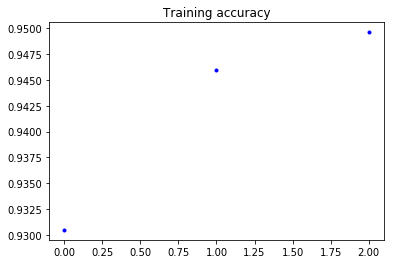

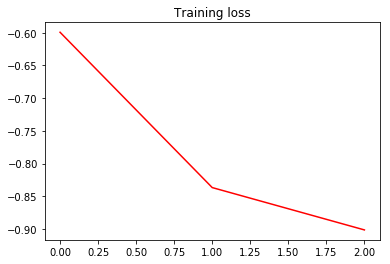

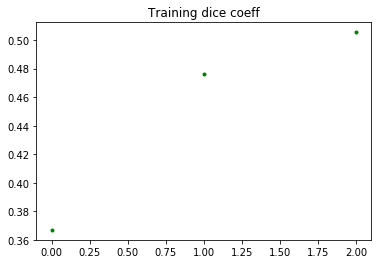

<Figure size 432x288 with 0 Axes>

In [19]:
def plot_training(history):
    acc = history.history['acc']
    print(acc)
    loss = history.history['loss']
    dice_coeff = history.history['dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b.')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'g.')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)